# Kuala Lumpur neighborhoods analysis

#Introduction/Business Problem
In this project we will compare different neighborhoods of the KL city based on property prices, types and venues around that neighborhood using machine learning clustering algorithms.

There are many reasons people relocate within city boundaries, e.g. getting a new job offer, kids moving to different school or moving away from bad neighborhood etc. This project will help such people to compare different neughborhoods of Kuala Lumpur city in terms of property types, prices, size and most importantly the venues around specific neighborhood.

#Dataset
We will use the [dataset](https://www.kaggle.com/dragonduck/property-listing-analysis) created by Jan S available on [Kaggle](https://www.kaggle.com). 

This dataset contains thousands of property listings scraped from iproperty.com for every neighborhood of Kuala Lumpurt city.

For venues around each neighborhood we will gather data from Foursquare.com

## Importing libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# Step 1. Data wrangling

## Download dataset

In [2]:
!wget -N https://www.dropbox.com/s/0t0ngkcjhu9zv0w/kl-properties_preprocessed.csv
df_property = pd.read_csv('kl-properties_preprocessed.csv')
df_property.head()

--2020-06-13 03:57:04--  https://www.dropbox.com/s/0t0ngkcjhu9zv0w/kl-properties_preprocessed.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/0t0ngkcjhu9zv0w/kl-properties_preprocessed.csv [following]
--2020-06-13 03:57:04--  https://www.dropbox.com/s/raw/0t0ngkcjhu9zv0w/kl-properties_preprocessed.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd98ce06f942c5a4726fd01e61f.dl.dropboxusercontent.com/cd/0/inline/A5jmMnEtoxcorX7GWqtayu_lJAtleCiP3U_3EPY3urHBicxfZWjFRLVotxCZnHQz2eWawB5adSdW-KO4PYCDvbfd-bZkZBJO9e7Cgo3FCwlL0ZlQXQeHh6A0wlD7pQhJxzg/file# [following]
--2020-06-13 03:57:04--  https://ucd98ce06f942c5a4726fd01e61f.dl.dropboxusercontent.com/cd/0/inline/A5jmMnEtoxcorX7GWqtayu_lJAtleCiP3U_3EPY3urHBicxfZWjFRLVotxCZ

,Location,Price,Rooms,Bathrooms,Car Parks,Furnishing,Property Type,Size,Price per Area,Price per Room
0,ampang,680,4.0,3.0,NaN,NaN,Terrace/Link House,1300.0,0.523077,170.000000
1,ampang,2000,3.0,2.0,2.0,NaN,Flat,1217.0,1.643385,666.666667
2,ampang,2700,2.0,2.0,NaN,Partly Furnished,Condominium,1400.0,1.928571,1350.000000
3,ampang,2100,2.0,2.0,1.0,Partly Furnished,Serviced Residence,856.0,2.453271,1050.000000
4,ampang,2400,2.0,2.0,NaN,Fully Furnished,Serviced Residence,856.0,2.803738,1200.000000


Drop unnecessary columns. We will focus on Property price, number of rooms/bathrooms, size in sqft, type, Price per Area and Price per Room.

In [3]:
df_property.drop(['Furnishing'], axis=1, inplace=True)
df_property.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Price per Area,Price per Room
0,ampang,680,4.0,3.0,NaN,Terrace/Link House,1300.0,0.523077,170.000000
1,ampang,2000,3.0,2.0,2.0,Flat,1217.0,1.643385,666.666667
2,ampang,2700,2.0,2.0,NaN,Condominium,1400.0,1.928571,1350.000000
3,ampang,2100,2.0,2.0,1.0,Serviced Residence,856.0,2.453271,1050.000000
4,ampang,2400,2.0,2.0,NaN,Serviced Residence,856.0,2.803738,1200.000000


In [4]:
df_property.dropna(inplace=True)
df_property.shape

(34606, 9)

In [5]:
df_property['Bathrooms'].describe()

count    34606.000000
mean         2.918598
std          1.517967
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max         20.000000
Name: Bathrooms, dtype: float64

In [6]:
df_property.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Price per Area,Price per Room
1,ampang,2000,3.0,2.0,2.0,Flat,1217.0,1.643385,666.666667
3,ampang,2100,2.0,2.0,1.0,Serviced Residence,856.0,2.453271,1050.000000
7,ampang,3300,3.0,2.0,2.0,Serviced Residence,950.0,3.473684,1100.000000
8,ampang,2500,1.0,1.0,1.0,Serviced Residence,680.0,3.676471,2500.000000
9,ampang,3500,2.0,2.0,1.0,Serviced Residence,860.0,4.069767,1750.000000


In [7]:
df_property.shape

(34606, 9)

#Step 2. Get neighborhood data
Now lets' get the unique neighborhods of KL and retrieve their latitude and longitude coordinates

In [8]:
districts = df_property.Location.unique()
districts

array(['ampang', 'ampang hilir', 'bandar damai perdana',
       'bandar menjalara', 'bangsar', 'bangsar south', 'batu caves',
       'brickfields', 'bukit bintang', 'bukit jalil',
       'bukit tunku (kenny hills)', 'cheras', 'city centre',
       'country heights damansara', 'damansara heights', 'desa pandan',
       'desa parkcity', 'desa petaling', 'dutamas', 'jalan bukit pantai',
       'jalan ipoh', 'jalan klang lama (old klang road)', 'jalan kuching',
       'jalan sultan ismail', 'kampung datuk keramat', 'kepong',
       'kl eco city', 'kl sentral', 'klcc', 'kuchai lama', 'mont kiara',
       'oug', 'pandan perdana', 'salak selatan', 'segambut', 'sentul',
       'seputeh', 'setapak', 'setiawangsa', 'sri hartamas',
       'sri petaling', 'sungai besi', 'sunway spk', 'taman desa',
       'taman melawati', 'taman tun dr ismail', 'titiwangsa',
       'wangsa maju'], dtype=object)

Create a districts dataframe

In [9]:
df_districts = pd.DataFrame(districts,columns=['District'])
df_districts['Latitude']=np.nan
df_districts['Longitude']=np.nan
df_districts

,District,Latitude,Longitude
0,ampang,NaN,NaN
1,ampang hilir,NaN,NaN
2,bandar damai perdana,NaN,NaN
3,bandar menjalara,NaN,NaN
4,bangsar,NaN,NaN
5,bangsar south,NaN,NaN
6,batu caves,NaN,NaN
7,brickfields,NaN,NaN
8,bukit bintang,NaN,NaN
9,bukit jalil,NaN,NaN


## Get Lat and Long coordinates of districts
Lets get the latitude and longitude data for each district

In [10]:
geolocator = Nominatim(user_agent="kl_explorer")
location = []
i=0
for d in districts:
  address = d+', Kuala Lumpur, MY'  
  location.append(geolocator.geocode(address))
  if location[i] is None:
    print('Coordinates of ', d, ' are missing')
  else :
    print('Coordinates of ', d, ' are:', location[i].latitude, location[i].longitude)
    df_districts['Latitude'].iloc[i] = geolocator.geocode(address).latitude
    df_districts['Longitude'].iloc[i] = geolocator.geocode(address).longitude
  i=i+1

Coordinates of  ampang  are: 3.15025555 101.76021009194159


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Coordinates of  ampang hilir  are: 3.1572437 101.73723561774395
Coordinates of  bandar damai perdana  are missing
Coordinates of  bandar menjalara  are: 3.1941357999999997 101.63363432715688
Coordinates of  bangsar  are: 3.13083 101.66944
Coordinates of  bangsar south  are: 3.1129733 101.6667294
Coordinates of  batu caves  are: 3.2018234 101.6710223
Coordinates of  brickfields  are: 3.1288572 101.6845528
Coordinates of  bukit bintang  are: 3.1471068 101.7086011
Coordinates of  bukit jalil  are: 3.0584527 101.6874386
Coordinates of  bukit tunku (kenny hills)  are: 3.1709295 101.6789455
Coordinates of  cheras  are: 3.107178 101.71649
Coordinates of  city centre  are: 3.1516964 101.6942371
Coordinates of  country heights damansara  are: 3.1780397999999996 101.6312235085507
Coordinates of  damansara heights  are: 3.151148 101.657635
Coordinates of  desa pandan  are: 3.1482687 101.7380746
Coordinates of  desa parkcity  are: 3.1866282 101.6303087
Coordinates of  desa petaling  are: 3.0841851

We noticed that one district (bandar damai perdana) is missing the coordinates, we will add that value manually

In [0]:
df_districts.loc[df_districts['District'] == 'bandar damai perdana','Latitude']=geolocator.geocode('bandar damai perdana').latitude
df_districts.loc[df_districts['District'] == 'bandar damai perdana','Longitude']=geolocator.geocode('bandar damai perdana').longitude

In [12]:
df_districts

,District,Latitude,Longitude
0,ampang,3.150256,101.760210
1,ampang hilir,3.157244,101.737236
2,bandar damai perdana,3.052914,101.735958
3,bandar menjalara,3.194136,101.633634
4,bangsar,3.130830,101.669440
5,bangsar south,3.112973,101.666729
6,batu caves,3.201823,101.671022
7,brickfields,3.128857,101.684553
8,bukit bintang,3.147107,101.708601
9,bukit jalil,3.058453,101.687439


## Create KL map with districts data

In [13]:
# create map of Tashkent using latitude and longitude values
address = "Kuala Lumpur, MY"
geolocator = Nominatim(user_agent="kl_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_kl = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, district in zip(df_districts['Latitude'], df_districts['Longitude'], df_districts['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_kl)  
    
map_kl

## Add Lat and Long columns to our initial dataset
We will use interesting method described [here](https://www.geeksforgeeks.org/python-creating-a-pandas-dataframe-column-based-on-a-given-condition/).

In [14]:
df_property.head(10)

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Price per Area,Price per Room
1,ampang,2000,3.0,2.0,2.0,Flat,1217.0,1.643385,666.666667
3,ampang,2100,2.0,2.0,1.0,Serviced Residence,856.0,2.453271,1050.000000
7,ampang,3300,3.0,2.0,2.0,Serviced Residence,950.0,3.473684,1100.000000
8,ampang,2500,1.0,1.0,1.0,Serviced Residence,680.0,3.676471,2500.000000
9,ampang,3500,2.0,2.0,1.0,Serviced Residence,860.0,4.069767,1750.000000
14,ampang,3000000,7.0,6.0,5.0,Bungalow,21635.0,138.664201,428571.428600
17,ampang,110000,3.0,2.0,1.0,Terrace/Link House,720.0,152.777778,36666.666670
19,ampang,1280000,5.0,3.0,3.0,Bungalow,7115.0,179.901616,256000.000000
20,ampang,1726560,8.0,6.0,6.0,Residential Land,9592.0,180.000000,215820.000000
24,ampang,1350000,5.0,3.0,7.0,Bungalow,7115.0,189.739986,270000.000000


We want to get Lat and Long values for each district and add to our original dataset above

In [15]:
df_districts.head()

,District,Latitude,Longitude
0,ampang,3.150256,101.760210
1,ampang hilir,3.157244,101.737236
2,bandar damai perdana,3.052914,101.735958
3,bandar menjalara,3.194136,101.633634
4,bangsar,3.130830,101.669440


First we create two dictionaries with Lat and Long information

In [0]:
lat_dict = dict(zip(df_districts[['District','Latitude']].District, df_districts[['District','Latitude']].Latitude))
lon_dict = dict(zip(df_districts[['District','Longitude']].District, df_districts[['District','Longitude']].Longitude))

In [17]:
print(lat_dict, "\n", lon_dict)

{'ampang': 3.15025555, 'ampang hilir': 3.1572437, 'bandar damai perdana': 3.0529145, 'bandar menjalara': 3.1941357999999997, 'bangsar': 3.13083, 'bangsar south': 3.1129733, 'batu caves': 3.2018234, 'brickfields': 3.1288572, 'bukit bintang': 3.1471068, 'bukit jalil': 3.0584527, 'bukit tunku (kenny hills)': 3.1709295, 'cheras': 3.107178, 'city centre': 3.1516964, 'country heights damansara': 3.1780397999999996, 'damansara heights': 3.151148, 'desa pandan': 3.1482687, 'desa parkcity': 3.1866282, 'desa petaling': 3.0841851, 'dutamas': 3.1790715, 'jalan bukit pantai': 3.1171489, 'jalan ipoh': 3.1677808, 'jalan klang lama (old klang road)': 3.1091345, 'jalan kuching': 3.156959, 'jalan sultan ismail': 3.1563348, 'kampung datuk keramat': 3.168953, 'kepong': 3.20280985, 'kl eco city': 3.1181468, 'kl sentral': 3.13259005, 'klcc': 3.1593058, 'kuchai lama': 3.0894376, 'mont kiara': 3.1699988, 'oug': 3.075488, 'pandan perdana': 3.1299182, 'salak selatan': 3.1020073999999997, 'segambut': 3.1864369, 

Next we will add Latitude and Longitude columns and map the values from our lists

In [0]:
df_property['Latitude'] = df_property['Location'].map(lat_dict)
df_property['Longitude'] = df_property['Location'].map(lon_dict)

In [19]:
df_property.head(5)

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Price per Area,Price per Room,Latitude,Longitude
1,ampang,2000,3.0,2.0,2.0,Flat,1217.0,1.643385,666.666667,3.150256,101.76021
3,ampang,2100,2.0,2.0,1.0,Serviced Residence,856.0,2.453271,1050.000000,3.150256,101.76021
7,ampang,3300,3.0,2.0,2.0,Serviced Residence,950.0,3.473684,1100.000000,3.150256,101.76021
8,ampang,2500,1.0,1.0,1.0,Serviced Residence,680.0,3.676471,2500.000000,3.150256,101.76021
9,ampang,3500,2.0,2.0,1.0,Serviced Residence,860.0,4.069767,1750.000000,3.150256,101.76021


#Step 3. Data analysis and clustering

##Onehot encoding

In [20]:
kl_onehot = pd.get_dummies(df_property, columns=["Property Type"], prefix=["Type"])
kl_onehot.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Size,Price per Area,Price per Room,Latitude,Longitude,Type_Apartment,Type_Bungalow,Type_Cluster House,Type_Condominium,Type_Flat,Type_Residential Land,Type_Semi-detached House,Type_Serviced Residence,Type_Terrace/Link House,Type_Townhouse
1,ampang,2000,3.0,2.0,2.0,1217.0,1.643385,666.666667,3.150256,101.76021,0,0,0,0,1,0,0,0,0,0
3,ampang,2100,2.0,2.0,1.0,856.0,2.453271,1050.000000,3.150256,101.76021,0,0,0,0,0,0,0,1,0,0
7,ampang,3300,3.0,2.0,2.0,950.0,3.473684,1100.000000,3.150256,101.76021,0,0,0,0,0,0,0,1,0,0
8,ampang,2500,1.0,1.0,1.0,680.0,3.676471,2500.000000,3.150256,101.76021,0,0,0,0,0,0,0,1,0,0
9,ampang,3500,2.0,2.0,1.0,860.0,4.069767,1750.000000,3.150256,101.76021,0,0,0,0,0,0,0,1,0,0


Next, let's group rows by district and by taking the mean of the frequency of occurrence of each offense

In [21]:
kl_grouped = kl_onehot.groupby('Location').mean().reset_index()
kl_grouped

,Location,Price,Rooms,Bathrooms,Car Parks,Size,Price per Area,Price per Room,Latitude,Longitude,Type_Apartment,Type_Bungalow,Type_Cluster House,Type_Condominium,Type_Flat,Type_Residential Land,Type_Semi-detached House,Type_Serviced Residence,Type_Terrace/Link House,Type_Townhouse
0,ampang,1.838012e+06,3.613235,3.301471,2.229412,2810.311765,755.544420,4.790992e+05,3.150256,101.760210,0.010294,0.133824,0.000000,0.245588,0.002941,0.007353,0.045588,0.450000,0.086765,0.017647
1,ampang hilir,3.325167e+06,3.801546,3.520619,2.484536,3265.652062,987.756431,7.672173e+05,3.157244,101.737236,0.000000,0.051546,0.000000,0.628866,0.000000,0.000000,0.010309,0.265464,0.028351,0.015464
2,bandar damai perdana,7.329299e+05,4.169492,3.254237,2.389831,1507.627119,495.683396,1.720422e+05,3.052914,101.735958,0.000000,0.000000,0.016949,0.000000,0.000000,0.000000,0.033898,0.000000,0.779661,0.169492
3,bandar menjalara,7.260876e+05,3.616246,2.428571,1.770308,2764.694678,500.646333,1.894830e+05,3.194136,101.633634,0.016807,0.005602,0.000000,0.509804,0.000000,0.000000,0.042017,0.266106,0.154062,0.005602
4,bangsar,4.032569e+06,4.207117,3.840328,2.797445,3841.863139,1048.380190,8.603454e+05,3.130830,101.669440,0.000000,0.193431,0.000000,0.537409,0.000000,0.000912,0.015511,0.115876,0.112226,0.024635
5,bangsar south,8.897530e+05,2.450000,1.903125,1.206250,1012.075000,893.373481,3.676235e+05,3.112973,101.666729,0.121875,0.003125,0.000000,0.178125,0.000000,0.000000,0.006250,0.681250,0.009375,0.000000
6,batu caves,6.199728e+05,2.918919,2.112613,1.761261,1116.576577,565.231861,2.191481e+05,3.201823,101.671022,0.054054,0.004505,0.000000,0.171171,0.004505,0.000000,0.004505,0.716216,0.045045,0.000000
7,brickfields,1.298960e+06,2.735294,2.039216,1.352941,1843.950980,715.183570,3.899695e+05,3.128857,101.684553,0.137255,0.029412,0.000000,0.460784,0.009804,0.000000,0.009804,0.352941,0.000000,0.000000
8,bukit bintang,1.938929e+06,2.643498,2.446188,1.439462,1517.639013,1255.117161,7.312284e+05,3.147107,101.708601,0.013453,0.000000,0.000000,0.320628,0.000000,0.000000,0.000000,0.663677,0.002242,0.000000
9,bukit jalil,1.450792e+06,3.626844,2.699607,2.037365,1817.893314,884.529571,3.349022e+05,3.058453,101.687439,0.095379,0.012783,0.000000,0.659292,0.000000,0.000492,0.007866,0.160275,0.061947,0.001967


## Clustering

Elbow Method for optimal value of k in KMeans

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f343e0b9e10>,
                 k=None, metric=None, model=None, timings=True)

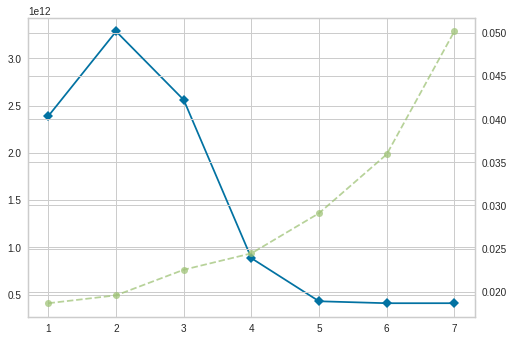

In [22]:
from yellowbrick.cluster import KElbowVisualizer

kl_grouped_clustering = kl_grouped.drop('Location', 1)

model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(1,8))
visualizer.fit(kl_grouped_clustering)        # Fit the data to the visualizer

In [23]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kl_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 4, 2, 2, 4, 2, 2, 2, 0, 0, 3, 2, 0, 1, 3, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 4, 2, 2, 0, 2,
       0, 0, 0, 2], dtype=int32)

In [0]:
#kl_grouped.drop(['Cluster Labels'], axis=1, inplace=True)
kl_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [25]:
kl_grouped.head()

,Cluster Labels,Location,Price,Rooms,Bathrooms,Car Parks,Size,Price per Area,Price per Room,Latitude,Longitude,Type_Apartment,Type_Bungalow,Type_Cluster House,Type_Condominium,Type_Flat,Type_Residential Land,Type_Semi-detached House,Type_Serviced Residence,Type_Terrace/Link House,Type_Townhouse
0,0,ampang,1.838012e+06,3.613235,3.301471,2.229412,2810.311765,755.544420,479099.240149,3.150256,101.760210,0.010294,0.133824,0.000000,0.245588,0.002941,0.007353,0.045588,0.450000,0.086765,0.017647
1,4,ampang hilir,3.325167e+06,3.801546,3.520619,2.484536,3265.652062,987.756431,767217.288928,3.157244,101.737236,0.000000,0.051546,0.000000,0.628866,0.000000,0.000000,0.010309,0.265464,0.028351,0.015464
2,2,bandar damai perdana,7.329299e+05,4.169492,3.254237,2.389831,1507.627119,495.683396,172042.224575,3.052914,101.735958,0.000000,0.000000,0.016949,0.000000,0.000000,0.000000,0.033898,0.000000,0.779661,0.169492
3,2,bandar menjalara,7.260876e+05,3.616246,2.428571,1.770308,2764.694678,500.646333,189483.044021,3.194136,101.633634,0.016807,0.005602,0.000000,0.509804,0.000000,0.000000,0.042017,0.266106,0.154062,0.005602
4,4,bangsar,4.032569e+06,4.207117,3.840328,2.797445,3841.863139,1048.380190,860345.366424,3.130830,101.669440,0.000000,0.193431,0.000000,0.537409,0.000000,0.000912,0.015511,0.115876,0.112226,0.024635


### Show clusters on a map

In [26]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kl_grouped['Latitude'], kl_grouped['Longitude'], kl_grouped['Location'], kl_grouped['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster-1],
        fill=False,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##Examine each cluster

### Cluster 0

In [27]:
kl_grouped.loc[kl_grouped['Cluster Labels'] == 0, kl_grouped.columns[[1] + list(range(2, kl_grouped.shape[1]))]]

,Location,Price,Rooms,Bathrooms,Car Parks,Size,Price per Area,Price per Room,Latitude,Longitude,Type_Apartment,Type_Bungalow,Type_Cluster House,Type_Condominium,Type_Flat,Type_Residential Land,Type_Semi-detached House,Type_Serviced Residence,Type_Terrace/Link House,Type_Townhouse
0,ampang,1.838012e+06,3.613235,3.301471,2.229412,2810.311765,755.544420,479099.240149,3.150256,101.760210,0.010294,0.133824,0.0,0.245588,0.002941,0.007353,0.045588,0.450000,0.086765,0.017647
8,bukit bintang,1.938929e+06,2.643498,2.446188,1.439462,1517.639013,1255.117161,731228.448804,3.147107,101.708601,0.013453,0.000000,0.0,0.320628,0.000000,0.000000,0.000000,0.663677,0.002242,0.000000
9,bukit jalil,1.450792e+06,3.626844,2.699607,2.037365,1817.893314,884.529571,334902.198874,3.058453,101.687439,0.095379,0.012783,0.0,0.659292,0.000000,0.000492,0.007866,0.160275,0.061947,0.001967
12,city centre,1.873873e+06,3.157623,2.850129,1.612403,2088.829457,929.859857,657674.745598,3.151696,101.694237,0.000000,0.018088,0.0,0.583979,0.000000,0.000000,0.005168,0.390181,0.002584,0.000000
16,desa parkcity,2.267923e+06,4.064242,3.654545,2.456970,2178.429091,1097.507451,557549.648706,3.186628,101.630309,0.000000,0.019394,0.0,0.471515,0.000000,0.000000,0.026667,0.000000,0.466667,0.015758
27,kl sentral,2.140316e+06,2.841155,2.826715,1.424188,1636.382671,1313.573247,823331.321269,3.132590,101.688001,0.000000,0.001805,0.0,0.279783,0.000000,0.000000,0.000000,0.718412,0.000000,0.000000
28,klcc,2.257115e+06,2.912523,2.698776,1.599844,1842.407967,1382.803604,822412.548449,3.159306,101.713203,0.001822,0.003124,0.0,0.370997,0.000260,0.000521,0.001302,0.619370,0.001302,0.001302
30,mont kiara,1.892699e+06,3.918304,3.554145,2.191902,2357.675611,828.361283,464969.573815,3.169999,101.652147,0.000000,0.023479,0.0,0.762817,0.000000,0.000000,0.017968,0.181121,0.014135,0.000479
31,oug,2.119315e+06,4.879310,3.948276,3.879310,4366.454023,523.630284,401798.771976,3.075488,101.670810,0.000000,0.310345,0.0,0.000000,0.000000,0.000000,0.149425,0.000000,0.413793,0.126437
36,seputeh,2.498797e+06,4.278810,3.684015,2.401487,3468.401487,752.164694,500084.790808,3.113687,101.681420,0.018587,0.267658,0.0,0.550186,0.000000,0.000000,0.052045,0.040892,0.070632,0.000000


These are mostly expensive neighborhoods with large units.

### Cluster 1

In [28]:
kl_grouped.loc[kl_grouped['Cluster Labels'] == 1, kl_grouped.columns[[1] + list(range(2, kl_grouped.shape[1]))]]

,Location,Price,Rooms,Bathrooms,Car Parks,Size,Price per Area,Price per Room,Latitude,Longitude,Type_Apartment,Type_Bungalow,Type_Cluster House,Type_Condominium,Type_Flat,Type_Residential Land,Type_Semi-detached House,Type_Serviced Residence,Type_Terrace/Link House,Type_Townhouse
13,country heights damansara,8.464653e+06,6.428571,6.653061,4.77551,9184.836735,915.861467,1.486345e+06,3.17804,101.631224,0.0,0.836735,0.0,0.0,0.0,0.040816,0.0,0.102041,0.020408,0.0


Country heights, Damansara stands alone as one of the most luxury neighborhood with luxury condos. This is the home of politicians, celebrities and rich people in general.

### Cluster 2

In [29]:
kl_grouped.loc[kl_grouped['Cluster Labels'] == 2, kl_grouped.columns[[1] + list(range(2, kl_grouped.shape[1]))]]

,Location,Price,Rooms,Bathrooms,Car Parks,Size,Price per Area,Price per Room,Latitude,Longitude,Type_Apartment,Type_Bungalow,Type_Cluster House,Type_Condominium,Type_Flat,Type_Residential Land,Type_Semi-detached House,Type_Serviced Residence,Type_Terrace/Link House,Type_Townhouse
2,bandar damai perdana,7.329299e+05,4.169492,3.254237,2.389831,1507.627119,495.683396,172042.224575,3.052914,101.735958,0.000000,0.000000,0.016949,0.000000,0.000000,0.000000,0.033898,0.000000,0.779661,0.169492
3,bandar menjalara,7.260876e+05,3.616246,2.428571,1.770308,2764.694678,500.646333,189483.044021,3.194136,101.633634,0.016807,0.005602,0.000000,0.509804,0.000000,0.000000,0.042017,0.266106,0.154062,0.005602
5,bangsar south,8.897530e+05,2.450000,1.903125,1.206250,1012.075000,893.373481,367623.522023,3.112973,101.666729,0.121875,0.003125,0.000000,0.178125,0.000000,0.000000,0.006250,0.681250,0.009375,0.000000
6,batu caves,6.199728e+05,2.918919,2.112613,1.761261,1116.576577,565.231861,219148.146894,3.201823,101.671022,0.054054,0.004505,0.000000,0.171171,0.004505,0.000000,0.004505,0.716216,0.045045,0.000000
7,brickfields,1.298960e+06,2.735294,2.039216,1.352941,1843.950980,715.183570,389969.521239,3.128857,101.684553,0.137255,0.029412,0.000000,0.460784,0.009804,0.000000,0.009804,0.352941,0.000000,0.000000
11,cheras,8.114027e+05,3.555595,2.629954,1.857945,1585.554192,530.992065,218241.764603,3.107178,101.716490,0.084181,0.036128,0.000000,0.434935,0.005612,0.000702,0.037531,0.180288,0.203788,0.016836
15,desa pandan,9.871434e+05,2.575221,2.070796,1.902655,1446.061947,724.178228,403996.165193,3.148269,101.738075,0.097345,0.000000,0.000000,0.000000,0.000000,0.000000,0.008850,0.884956,0.008850,0.000000
17,desa petaling,3.763140e+05,2.981308,2.084112,1.205607,982.971963,362.211036,120646.604364,3.084185,101.703552,0.317757,0.000000,0.000000,0.607477,0.046729,0.000000,0.009346,0.000000,0.018692,0.000000
18,dutamas,1.040169e+06,3.492205,2.977728,1.886414,1667.741648,630.264118,312218.774870,3.179072,101.655701,0.000000,0.004454,0.000000,0.786192,0.000000,0.001114,0.030067,0.165924,0.012249,0.000000
19,jalan bukit pantai,1.049186e+06,2.971193,2.238683,1.662551,1734.835391,588.792004,335195.812794,3.117149,101.668217,0.000000,0.057613,0.000000,0.769547,0.004115,0.000000,0.004115,0.160494,0.004115,0.000000


This is the place for people with middle income

### Cluster 3

In [30]:
kl_grouped.loc[kl_grouped['Cluster Labels'] == 3, kl_grouped.columns[[1] + list(range(2, kl_grouped.shape[1]))]]

,Location,Price,Rooms,Bathrooms,Car Parks,Size,Price per Area,Price per Room,Latitude,Longitude,Type_Apartment,Type_Bungalow,Type_Cluster House,Type_Condominium,Type_Flat,Type_Residential Land,Type_Semi-detached House,Type_Serviced Residence,Type_Terrace/Link House,Type_Townhouse
10,bukit tunku (kenny hills),5.891314e+06,5.175000,5.11875,3.59375,7174.525000,856.713864,9.927273e+05,3.170930,101.678945,0.031250,0.287500,0.0,0.646875,0.0,0.012500,0.021875,0.000000,0.000000,0.00000
14,damansara heights,5.140485e+06,4.778774,4.54559,3.22272,5200.532138,1086.485492,1.020633e+06,3.151148,101.657635,0.001495,0.433483,0.0,0.137519,0.0,0.001495,0.089686,0.284006,0.049327,0.00299


Another expensive neighborhoods with luxury homes

### Cluster 4

In [31]:
kl_grouped.loc[kl_grouped['Cluster Labels'] == 4, kl_grouped.columns[[1] + list(range(2, kl_grouped.shape[1]))]]

,Location,Price,Rooms,Bathrooms,Car Parks,Size,Price per Area,Price per Room,Latitude,Longitude,Type_Apartment,Type_Bungalow,Type_Cluster House,Type_Condominium,Type_Flat,Type_Residential Land,Type_Semi-detached House,Type_Serviced Residence,Type_Terrace/Link House,Type_Townhouse
1,ampang hilir,3.325167e+06,3.801546,3.520619,2.484536,3265.652062,987.756431,767217.288928,3.157244,101.737236,0.0,0.051546,0.000000,0.628866,0.0,0.000000,0.010309,0.265464,0.028351,0.015464
4,bangsar,4.032569e+06,4.207117,3.840328,2.797445,3841.863139,1048.380190,860345.366424,3.130830,101.669440,0.0,0.193431,0.000000,0.537409,0.0,0.000912,0.015511,0.115876,0.112226,0.024635
39,sri hartamas,3.188067e+06,4.559917,4.338843,2.952479,3465.564050,931.572004,637054.086887,3.161544,101.652062,0.0,0.113636,0.004132,0.340909,0.0,0.000000,0.188017,0.204545,0.130165,0.018595


Neighborhoods for upper income category

#Step 4. Foursquare data
Next let's analyse the same neighborhoods using the data obtained from Foursquare

##Foursquare crdentials

In [0]:
CLIENT_ID = 'HOGPJE3HEQSUCCOHACGSFU22DYGFV4NM3VG2WELOIHXBH0QF' # your Foursquare ID (fake)
CLIENT_SECRET = 'Y0DLYDDF2YBRYE2IITVXVPLIYZ4YAAI2VR0FEKDKZ3UDB1MA' # your Foursquare Secret
VERSION = '20200612' # Foursquare API version
LIMIT=100

## Explore KL neighborhoods

In [0]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [34]:
df_districts.head()

,District,Latitude,Longitude
0,ampang,3.150256,101.760210
1,ampang hilir,3.157244,101.737236
2,bandar damai perdana,3.052914,101.735958
3,bandar menjalara,3.194136,101.633634
4,bangsar,3.130830,101.669440


In [35]:
kl_venues = getNearbyVenues(names=df_districts['District'], latitudes=df_districts['Latitude'],longitudes=df_districts['Longitude'])

ampang
ampang hilir
bandar damai perdana
bandar menjalara
bangsar
bangsar south
batu caves
brickfields
bukit bintang
bukit jalil
bukit tunku (kenny hills)
cheras
city centre
country heights damansara
damansara heights
desa pandan
desa parkcity
desa petaling
dutamas
jalan bukit pantai
jalan ipoh
jalan klang lama (old klang road)
jalan kuching
jalan sultan ismail
kampung datuk keramat
kepong
kl eco city
kl sentral
klcc
kuchai lama
mont kiara
oug
pandan perdana
salak selatan
segambut
sentul
seputeh
setapak
setiawangsa
sri hartamas
sri petaling
sungai besi
sunway spk
taman desa
taman melawati
taman tun dr ismail
titiwangsa
wangsa maju


Let's check returned venues

In [36]:
kl_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ampang,3.150256,101.76021,老妈子海南鸡饭,3.147979,101.760940,Asian Restaurant
1,ampang,3.150256,101.76021,Hookaholic RNK,3.151498,101.759573,Hookah Bar
2,ampang,3.150256,101.76021,Rumah Api (A.K.A Gudang Noisy),3.149553,101.762267,Concert Hall
3,ampang,3.150256,101.76021,Sbai Thai Mini Market & Thai Seafood Restaurant,3.147143,101.762903,Thai Restaurant
4,ampang,3.150256,101.76021,呀吃祖传黎氏兄弟跌打医馆(安邦分行),3.148067,101.762579,Outlet Store


Number of venues for each neighborhood

In [37]:
kl_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
ampang,24,24,24,24,24,24
ampang hilir,32,32,32,32,32,32
bandar damai perdana,9,9,9,9,9,9
bandar menjalara,35,35,35,35,35,35
bangsar,89,89,89,89,89,89
bangsar south,89,89,89,89,89,89
batu caves,36,36,36,36,36,36
brickfields,62,62,62,62,62,62
bukit bintang,89,89,89,89,89,89


In [38]:
print('There are {} uniques categories.'.format(len(kl_venues['Venue Category'].unique())))

There are 251 uniques categories.


##Analyze each neighborhood

In [39]:
# one hot encoding
kl_venues_onehot = pd.get_dummies(kl_venues[['Venue Category']], prefix="", prefix_sep="")
columns = kl_venues_onehot.columns.to_list()
# rearrange columns
columns.insert(0,'Neighborhood')
# add neighborhood column back to dataframe
kl_venues_onehot['Neighborhood'] = kl_venues['Neighborhood'] 
# move neighborhood column to the first column
kl_venues_onehot = kl_venues_onehot[columns]
kl_venues_onehot.head()

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Belgian Restaurant,Betting Shop,Big Box Store,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Casino,Chettinad Restaurant,Chinese Breakfast Place,Chinese Restaurant,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,German Restaurant,Gourmet Shop,Government Building,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Hardware Store,Health & Beauty Service,Herbs & Spices Store,Historic Site,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Housing Development,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Kushikatsu Restaurant,Lebanese Restaurant,Light Rail Station,Lingerie Store,Lounge,Malay Restaurant,Mamak Restaurant,Market,Martial Arts Dojo,Massage Studio,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Night Market,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Outlet Store,Padangnese Restaurant,Pakistani Restaurant,Park,Pawn Shop,Performing Arts Venue,Persian Restaurant,Pet Café,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Poke Place,Police Station,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Udon Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Women's Store,Yoga Studio
0,ampang,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [40]:
kl_venues_onehot.shape

(1885, 252)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [41]:
kl_venues_grouped = kl_venues_onehot.groupby('Neighborhood').mean().reset_index()
kl_venues_grouped

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Belgian Restaurant,Betting Shop,Big Box Store,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Casino,Chettinad Restaurant,Chinese Breakfast Place,Chinese Restaurant,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,German Restaurant,Gourmet Shop,Government Building,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Hardware Store,Health & Beauty Service,Herbs & Spices Store,Historic Site,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Housing Development,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Kushikatsu Restaurant,Lebanese Restaurant,Light Rail Station,Lingerie Store,Lounge,Malay Restaurant,Mamak Restaurant,Market,Martial Arts Dojo,Massage Studio,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Night Market,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Outlet Store,Padangnese Restaurant,Pakistani Restaurant,Park,Pawn Shop,Performing Arts Venue,Persian Restaurant,Pet Café,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Poke Place,Police Station,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Udon Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Women's Store,Yoga Studio
0,ampang,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

Let's print each neighborhood along with the top 5 most common venues

In [42]:
num_top_venues = 5

for hood in kl_venues_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = kl_venues_grouped[kl_venues_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ampang----
                venue  freq
0    Malay Restaurant  0.17
1    Asian Restaurant  0.12
2     Thai Restaurant  0.08
3  Seafood Restaurant  0.08
4          Hookah Bar  0.04


----ampang hilir----
                 venue  freq
0                 Café  0.09
1  Japanese Restaurant  0.09
2                  Spa  0.06
3           Donut Shop  0.06
4          Coffee Shop  0.06


----bandar damai perdana----
              venue  freq
0              Café  0.33
1  Department Store  0.11
2     Big Box Store  0.11
3            Bistro  0.11
4    Cosmetics Shop  0.11


----bandar menjalara----
                           venue  freq
0             Chinese Restaurant  0.23
1            Japanese Restaurant  0.11
2                           Café  0.09
3  Vegetarian / Vegan Restaurant  0.09
4                   Noodle House  0.06


----bangsar----
               venue  freq
0  Indian Restaurant  0.11
1         Steakhouse  0.06
2                Bar  0.06
3     Ice Cream Shop  0.06
4        Coffee Sho

##Create a new df for top 10 neighborhoods

In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [44]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kl_venues_grouped['Neighborhood']

for ind in np.arange(kl_venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kl_venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ampang,Malay Restaurant,Asian Restaurant,Thai Restaurant,Seafood Restaurant,Spa,Gym / Fitness Center,Outlet Store,Flea Market,Light Rail Station,Trail
1,ampang hilir,Japanese Restaurant,Café,Coffee Shop,Spa,Donut Shop,Electronics Store,Shopping Mall,Sporting Goods Shop,Playground,Sandwich Place
2,bandar damai perdana,Café,Chinese Restaurant,Restaurant,Bistro,Big Box Store,Department Store,Cosmetics Shop,Doctor's Office,Food & Drink Shop,Fruit & Vegetable Store
3,bandar menjalara,Chinese Restaurant,Japanese Restaurant,Café,Vegetarian / Vegan Restaurant,Asian Restaurant,Noodle House,Hotpot Restaurant,Bookstore,Belgian Restaurant,Thai Restaurant
4,bangsar,Indian Restaurant,Ice Cream Shop,Steakhouse,Bar,Coffee Shop,Cosmetics Shop,Shopping Mall,Juice Bar,Café,Chinese Restaurant


#Step 5. Clustering based on venues

In [45]:
kl_venues_grouped_clustering = kl_venues_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kl_venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 4, 1, 1, 1, 2, 3, 1, 2, 2,
       1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [46]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kl_venues_merged = df_districts

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kl_venues_merged = kl_venues_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='District')

kl_venues_merged.head() # check the last columns!

,District,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ampang,3.150256,101.760210,1,Malay Restaurant,Asian Restaurant,Thai Restaurant,Seafood Restaurant,Spa,Gym / Fitness Center,Outlet Store,Flea Market,Light Rail Station,Trail
1,ampang hilir,3.157244,101.737236,1,Japanese Restaurant,Café,Coffee Shop,Spa,Donut Shop,Electronics Store,Shopping Mall,Sporting Goods Shop,Playground,Sandwich Place
2,bandar damai perdana,3.052914,101.735958,1,Café,Chinese Restaurant,Restaurant,Bistro,Big Box Store,Department Store,Cosmetics Shop,Doctor's Office,Food & Drink Shop,Fruit & Vegetable Store
3,bandar menjalara,3.194136,101.633634,2,Chinese Restaurant,Japanese Restaurant,Café,Vegetarian / Vegan Restaurant,Asian Restaurant,Noodle House,Hotpot Restaurant,Bookstore,Belgian Restaurant,Thai Restaurant
4,bangsar,3.130830,101.669440,1,Indian Restaurant,Ice Cream Shop,Steakhouse,Bar,Coffee Shop,Cosmetics Shop,Shopping Mall,Juice Bar,Café,Chinese Restaurant


##Create a clusters map

In [47]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kl_venues_merged['Latitude'], kl_venues_merged['Longitude'], kl_venues_merged['District'], kl_venues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##Lets analyse each cluster

###Cluster 0

In [48]:
kl_venues_merged.loc[kl_venues_merged['Cluster Labels'] == 0, kl_venues_merged.columns[[0] + list(range(4, kl_venues_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,segambut,Malay Restaurant,Department Store,Coffee Shop,Food Stand,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fish Market


### Cluster 1

In [49]:
kl_venues_merged.loc[kl_venues_merged['Cluster Labels'] == 1, kl_venues_merged.columns[[0] + list(range(4, kl_venues_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ampang,Malay Restaurant,Asian Restaurant,Thai Restaurant,Seafood Restaurant,Spa,Gym / Fitness Center,Outlet Store,Flea Market,Light Rail Station,Trail
1,ampang hilir,Japanese Restaurant,Café,Coffee Shop,Spa,Donut Shop,Electronics Store,Shopping Mall,Sporting Goods Shop,Playground,Sandwich Place
2,bandar damai perdana,Café,Chinese Restaurant,Restaurant,Bistro,Big Box Store,Department Store,Cosmetics Shop,Doctor's Office,Food & Drink Shop,Fruit & Vegetable Store
4,bangsar,Indian Restaurant,Ice Cream Shop,Steakhouse,Bar,Coffee Shop,Cosmetics Shop,Shopping Mall,Juice Bar,Café,Chinese Restaurant
5,bangsar south,Café,Coffee Shop,Malay Restaurant,Restaurant,Japanese Restaurant,Italian Restaurant,Bakery,Convenience Store,Asian Restaurant,Chinese Restaurant
7,brickfields,Indian Restaurant,Hotel,Convenience Store,Coffee Shop,Food Court,Chinese Restaurant,Café,South Indian Restaurant,Malay Restaurant,Noodle House
8,bukit bintang,Hotel,Café,Coffee Shop,Asian Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Spa,Lounge,BBQ Joint,Sandwich Place
9,bukit jalil,Athletics & Sports,Stadium,Bus Stop,Park,Café,Gym,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain
10,bukit tunku (kenny hills),Tennis Court,Pool Hall,Convenience Store,Bistro,Malay Restaurant,Stadium,Pool,Coworking Space,Dim Sum Restaurant,Flower Shop
12,city centre,Indian Restaurant,Malay Restaurant,Coffee Shop,Bubble Tea Shop,Café,Food Court,Bakery,Hotel,South Indian Restaurant,Food Truck


### Cluster 2

In [50]:
kl_venues_merged.loc[kl_venues_merged['Cluster Labels'] == 2, kl_venues_merged.columns[[0] + list(range(4, kl_venues_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,bandar menjalara,Chinese Restaurant,Japanese Restaurant,Café,Vegetarian / Vegan Restaurant,Asian Restaurant,Noodle House,Hotpot Restaurant,Bookstore,Belgian Restaurant,Thai Restaurant
6,batu caves,Chinese Restaurant,Malay Restaurant,Food Truck,Asian Restaurant,Flea Market,Food Court,BBQ Joint,Thai Restaurant,Restaurant,Bowling Alley
11,cheras,Fast Food Restaurant,Asian Restaurant,Food Truck,Athletics & Sports,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fruit & Vegetable Store,Fish Market,Fountain
17,desa petaling,Chinese Restaurant,Malay Restaurant,Breakfast Spot,Asian Restaurant,Seafood Restaurant,Fried Chicken Joint,Department Store,Steakhouse,Other Great Outdoors,Gym
20,jalan ipoh,Asian Restaurant,Chinese Restaurant,Malay Restaurant,Hotel,Vegetarian / Vegan Restaurant,Convenience Store,Pakistani Restaurant,Toy / Game Store,Café,Noodle House
21,jalan klang lama (old klang road),Chinese Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Japanese Restaurant,Hotpot Restaurant,Mexican Restaurant,Hotel,Auto Garage,Chinese Breakfast Place,Pet Store
25,kepong,Chinese Restaurant,Auto Workshop,Soccer Field,Malay Restaurant,Basketball Court,Food Truck,Bakery,Badminton Court,BBQ Joint,Asian Restaurant
29,kuchai lama,Chinese Restaurant,Asian Restaurant,Hotpot Restaurant,Beer Bar,Malay Restaurant,Noodle House,Dessert Shop,Convenience Store,Italian Restaurant,Pub
31,oug,Chinese Restaurant,Asian Restaurant,Coffee Shop,Malay Restaurant,Vegetarian / Vegan Restaurant,Cantonese Restaurant,Noodle House,Restaurant,Café,Indian Restaurant
32,pandan perdana,Chinese Restaurant,Asian Restaurant,Malay Restaurant,Pizza Place,Convenience Store,Hotel,Coffee Shop,Snack Place,Bistro,Hakka Restaurant


### Clusters and 4

In [51]:
kl_venues_merged.loc[kl_venues_merged['Cluster Labels'] == 3, kl_venues_merged.columns[[0] + list(range(4, kl_venues_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,dutamas,Pool,Café,Yoga Studio,Fish Market,Fruit & Vegetable Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain,Food Truck


In [52]:
kl_venues_merged.loc[kl_venues_merged['Cluster Labels'] == 4, kl_venues_merged.columns[[0] + list(range(4, kl_venues_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,country heights damansara,Trail,Art Gallery,Tea Room,Light Rail Station,Yoga Studio,Food Court,Flower Shop,Food,Food & Drink Shop,Food Stand


#Step 6. Compare two clustering results

## Create markers for KL venues clustering
Inner circle indicates clustering by Neighborhood venues

In [0]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kl_venues_merged['Latitude'], kl_venues_merged['Longitude'], kl_venues_merged['District'], kl_venues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)       

## Create markers for KL property clustering
Outer circles indicate the clustering by Property prices

In [54]:
# create map
#map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kl_grouped['Latitude'], kl_grouped['Longitude'], kl_grouped['Location'], kl_grouped['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=False,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Conclusion

In conclusion, we can say that neighborhoods with similar property types/values are very similar in terms of venues around that neighborhood. 

This map could be good visual tool for someone who is planning to relocate within KL city boundaries as it shows the relation between the neighborhood and venues around it.